<a href="https://colab.research.google.com/github/yeungjosh/resnet-perturbations-riselab/blob/master/cifar10_perturbation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install resnet_pytorch
!git clone https://github.com/amirgholami/adahessian.git
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py


Cloning into 'adahessian'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 498 (delta 51), reused 60 (delta 24), pack-reused 387
Receiving objects: 100% (498/498), 1.98 MiB | 25.39 MiB/s, done.
Resolving deltas: 100% (163/163), done.
--2021-03-13 00:40:14--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2021-03-13 00:40:14 (64.6 MB/s) - ‘helper.py’ saved [2813/2813]



In [2]:
from matplotlib import pylab as plt

from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import CIFAR10
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time

from torch import nn, optim

import torch
import torch.nn as nn
import torch.nn.init as init
from resnet_pytorch import ResNet 

import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from copy import copy, deepcopy
from torchvision import transforms

# display image
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

import numpy as np

# from tools import * 
# from models import *
# from get_data import *
import adahessian.image_classification.optim_adahessian
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()



resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



In [5]:
adahessian_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_adahessian_best.pkl")
new_bn = resnet20()
new_bn.load_state_dict(adahessian_state_dict)

<All keys matched successfully>

In [6]:
# adadelta.load_state_dict(F"/content/gdrive/My Drive/cifar10_resnet_adadelta_best.pkl")
# adam.load_state_dict(F"/content/gdrive/My Drive/cifar10_resnet_adam_best.pkl"  )
# sgd.load_state_dict(F"/content/gdrive/My Drive/cifar10_resnet_sgd_best.pkl")

adadelta = resnet20()
adadelta_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_adadelta_best.pkl")
adadelta.load_state_dict(adadelta_state_dict)

adam = resnet20()
adam_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_adam_best.pkl")
adam.load_state_dict(adam_state_dict)

sgd = resnet20()
sgd_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_sgd_best.pkl")
sgd.load_state_dict(sgd_state_dict)

adahessian_best = resnet20()
adahessian_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_adahessian_best.pkl")
adahessian_best.load_state_dict(adahessian_state_dict)

frank_wolfe_L2 = resnet20()
frank_wolfe_L2_state_dict = torch.load(F"/content/gdrive/My Drive/cifar10_resnet_frank_wolfe_L2_norm_best.pkl")
frank_wolfe_L2.load_state_dict(frank_wolfe_L2_state_dict)

# adadelta = torch.load(F"/content/gdrive/My Drive/resnet_adadelta_best.pkl",map_location='cpu', )
# adam = torch.load(F"/content/gdrive/My Drive/resnet_adam_best.pkl" ,map_location='cpu', )
# sgd = torch.load(F"/content/gdrive/My Drive/resnet_sgd_best.pkl" ,map_location='cpu', )

<All keys matched successfully>

In [7]:
def getData(name='cifar10', train_bs=128, test_bs=1000):    
    if name == 'svhn':
        train_loader = torch.utils.data.DataLoader(
    datasets.SVHN('../data', split='extra', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('../data', split='test', download=True,transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=test_bs, shuffle=False)
    if name == 'mnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=test_bs, shuffle=False)
    if name == 'emnist':
        train_loader = torch.utils.data.DataLoader(
            datasets.EMNIST('../data', train=True, download=True, split='balanced',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1751,), (0.3267,))
                           ])),
            batch_size=train_bs, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            datasets.EMNIST('../data', train=False, split='balanced', transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1751,), (0.3267,))
                           ])),
            batch_size=test_bs, shuffle=False)
    if name == 'cifar10':
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_bs, shuffle=True)
        testset = datasets.CIFAR10(root='../data', train=False, download=False, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_bs, shuffle=False)
    if name == 'cifar100':
        transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
        trainset = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_bs, shuffle=True)
        testset = datasets.CIFAR100(root='../data', train=False, download=False, transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_bs, shuffle=False)
    if name == 'tinyimagenet':      
        normalize = transforms.Normalize(mean=[0.44785526394844055, 0.41693055629730225, 0.36942949891090393],
                                     std=[0.2928885519504547, 0.28230994939804077, 0.2889912724494934])
        train_dataset = datasets.ImageFolder(
        '../data/tiny-imagenet-200/train',
        transforms.Compose([
            transforms.RandomCrop(64, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_bs, shuffle=True, num_workers=4, pin_memory=False)
        test_dataset = datasets.ImageFolder(
        '../data/tiny-imagenet-200/val',
        transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_bs, shuffle=False)
    return train_loader, test_loader

In [8]:
# T = 28*28

train_loader, test_loader = getData(name='cifar10', train_bs=128, test_bs=1000)



Extracting ../data/cifar-10-python.tar.gz to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


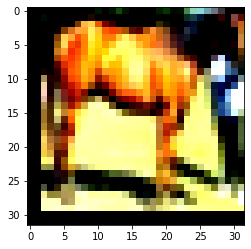

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[2]))
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# imshow(images[0], normalize=False)

In [10]:
# write batchwise sp noise

def sp(image, amount):
      num_channels, row,col = image.shape
      s_vs_p = 0.5
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      idx = np.random.choice(range(num_channels * row * col), np.int(num_salt), False)
      # out = out.reshape(image.size, -1)
      out = out.flatten()
      out[idx] = 1.0
      out = out.reshape(num_channels, row, col)
      
      # Pepper mode
      num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
      idx = np.random.choice(range(num_channels*row*col), np.int(num_pepper), False)
      out = out.flatten()
      out[idx] = 0.
      out = out.reshape(num_channels, row, col)
      out = np.expand_dims(out,0)
      return out

def sp_wrapper(data, amount):
    np.random.seed(12345)
    for i in range(data.shape[0]):
        data_numpy = data[i,:,:,:].data.cpu().numpy()
        noisy_input = sp(data_numpy, amount)
        data[i,:,:,:] = torch.tensor(noisy_input).float().to(device)
    return data 

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Pertubation analysis
def perturb(model, test_loader, noise_level, ntype='white'):
    acc = []
    if torch.cuda.is_available():
      model.cuda()

    for level in tqdm(noise_level):
        correct = 0
        total_num = 0        
        
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            #print(data.min())
            #print(data.max())
            
            if ntype == 'white':
                np.random.seed(123456)
                data_perturbed = data + torch.randn(data.shape).to(device) * level
                data_perturbed = torch.clamp(data_perturbed, 0, 1)

            elif ntype == 'sp':
                data_perturbed = sp_wrapper(data, level)

            # print(data_perturbed)
            # images, labels = next(iter(train_loader))
            # imshow(torchvision.utils.make_grid(data.cpu()[0]))
            # imshow(torchvision.utils.make_grid(data_perturbed.cpu()[0]))
            # plt.imshow(np.squeeze(data.cpu()[0]))
            # plt.imshow(data.cpu()[0])
            # to_img(data[1:])
            # to_img(data_perturbed)

            output = model(data_perturbed)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            total_num += len(data)
                
        accuracy = correct / total_num
        print(accuracy)
        acc.append(accuracy)
    
    return acc   

In [16]:
# ntype = 'white'
ntype = 'sp'

if ntype == 'white':
    noise_level = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
    # noise_level = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    # noise_level = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25]
    noise_level = [0.0]
    
else:
    noise_level = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    # noise_level = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 1.1, 1.2,1.3,1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
    # noise_level = [1.5, 1.6, 1.7, 1.8, 1.9, 2]
    # noise_level = [0.0]

start = time.time()

acc_adahessian_best_sp = perturb(adahessian_best, test_loader, noise_level, ntype=ntype)
print(acc_adahessian_best_sp)
acc_frank_wolfe_L2_sp = perturb(frank_wolfe_L2, test_loader, noise_level, ntype=ntype)
print(acc_frank_wolfe_L2_sp)
acc_adadelta_sp = perturb(adadelta, test_loader, noise_level, ntype=ntype)
print(acc_adadelta_sp)
acc_adam_sp = perturb(adam, test_loader, noise_level, ntype=ntype)
print(acc_adam_sp)
acc_sgd_sp = perturb(sgd, test_loader, noise_level, ntype=ntype)
print(acc_sgd_sp)


end = time.time()
print(end - start)


0.82



0.7924



0.7524



0.7184



0.6828



0.6335



0.5726



0.523



0.4403



0.3771



0.3242



0.2835



0.251

[0.82, 0.7924, 0.7524, 0.7184, 0.6828, 0.6335, 0.5726, 0.523, 0.4403, 0.3771, 0.3242, 0.2835, 0.251]



0.8827



0.8568



0.8136



0.7676



0.7331



0.6814



0.6118



0.5616



0.4755



0.4053



0.3472



0.3056



0.268

[0.8827, 0.8568, 0.8136, 0.7676, 0.7331, 0.6814, 0.6118, 0.5616, 0.4755, 0.4053, 0.3472, 0.3056, 0.268]



0.8825



0.8466



0.7955



0.7457



0.7026



0.6435



0.5566



0.5024



0.3985



0.3284



0.2723



0.2397



0.2133

[0.8825, 0.8466, 0.7955, 0.7457, 0.7026, 0.6435, 0.5566, 0.5024, 0.3985, 0.3284, 0.2723, 0.2397, 0.2133]



0.885



0.8582



0.7994



0.7567



0.7145



0.6589



0.5876



0.5266



0.4265



0.3635



0.3067



0.2647



0.2336

[0.885, 0.8582, 0.7994, 0.7567, 0.7145, 0.6589, 0.5876, 0.5266, 0.4265, 0.3635, 0.3067, 0.2647, 0.2336]



0.8693



0.8441



0.7958



0.7603



0.7219



0.6697



0.605



0.5542



0.4626



0.3906



0.3354



0.2934



0.2577

[0.8693, 0.8441, 0.7958, 0.7603, 0.7219, 0.6697, 0.605, 0.5542, 0.4626, 0.3906, 0.3354, 0.2934, 0.2577]
785.9812481403351


In [17]:
print(acc_adadelta_sp)
print(acc_adam_sp)
print(acc_sgd_sp)

[0.8825, 0.8466, 0.7955, 0.7457, 0.7026, 0.6435, 0.5566, 0.5024, 0.3985, 0.3284, 0.2723, 0.2397, 0.2133]
[0.885, 0.8582, 0.7994, 0.7567, 0.7145, 0.6589, 0.5876, 0.5266, 0.4265, 0.3635, 0.3067, 0.2647, 0.2336]
[0.8693, 0.8441, 0.7958, 0.7603, 0.7219, 0.6697, 0.605, 0.5542, 0.4626, 0.3906, 0.3354, 0.2934, 0.2577]


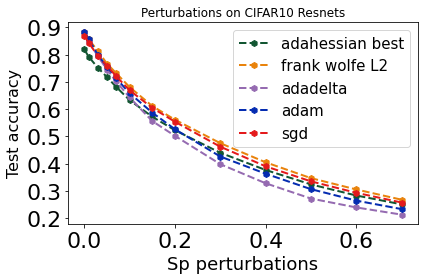

In [19]:


plt.title("Perturbations on CIFAR10 Resnets") 
plt.plot(noise_level, acc_adahessian_best_sp, 'h--', lw=2, c='#125632', label='adahessian best')
plt.plot(noise_level, acc_frank_wolfe_L2_sp, 'h--', lw=2, c='#e9830c', label='frank wolfe L2')
plt.plot(noise_level, acc_adadelta_sp, 'h--', lw=2, c='#956bb1', label='adadelta')
plt.plot(noise_level, acc_adam_sp, 'h--', lw=2, c='#052cb1', label='adam')
plt.plot(noise_level, acc_sgd_sp, 'h--', lw=2, c='#e41a1c', label='sgd')
plt.xlabel('Sp perturbations', fontsize=18)
plt.ylabel('Test accuracy', fontsize=16)
plt.tick_params(axis='y', labelsize=22) 
plt.tick_params(axis='x', labelsize=22) 
plt.locator_params(axis='y', nbins=8)  
plt.legend(fontsize=15)  
plt.tight_layout()
plt.show()
# plt.savefig('F"/content/gdrive/My Drive/plot_perturb.pdf')     


In [ ]:
plt.savefig('F"/content/gdrive/My Drive/plot_perturb.pdf')     
